In [1]:
!date

Wed Apr 16 04:51:44 PM EDT 2025


In [2]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

In [3]:
import os
import numpy as np
import pandas as pd
import ants
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm

In [4]:
def load_pickle(fn):
    if os.path.exists(fn):
        with open(fn, 'rb') as file:
            loaded_dict = pickle.load(file)
    return loaded_dict

In [5]:
def pretty_bar_plot(arrs,group_labels,bar_color):
    # Organize data into a list for easy looping
    #arrs = [face_preproc_vals, face_compcor_vals, face_signal_vals]
    #group_labels = ['Face Preproc', 'Face CompCor', 'Face Signal']

    # Calculate means and standard deviations
    means = np.array([arr.mean() for arr in arrs])
    stds = np.array([arr.std() for arr in arrs])
    xs = np.arange(len(arrs))  # positions for each bar

    # Set the desired color for the bars (change this variable as needed)
    #bar_color = 'red'  # e.g., 'red', 'blue', 'green', etc.

    # Create the figure with appropriate dimensions for publication
    #plt.figure(figsize=(8, 6))

    # Plot bars with error bars
    bar_container = plt.bar(xs, means, yerr=stds, capsize=5,
                            color=bar_color, edgecolor='black', alpha=0.8)

    # Overlay individual data points with jitter to avoid overlap.
    for i, arr in enumerate(arrs):
        # Add a little random jitter to the x-positions so points don't overlay exactly.
        jitter = np.random.normal(0, 0.03, size=len(arr))
        plt.scatter(np.full(len(arr), xs[i]) + jitter, arr,
                    color='black', zorder=5, s=50, alpha=0.85)

    # Increase font sizes and set text bold for clarity in print.
    plt.xticks(xs, group_labels, fontsize=16, fontweight='bold')
    #plt.xlabel('Processing Type', fontsize=18, fontweight='bold')
    plt.ylabel('Corr. with Regressor', fontsize=18, fontweight='bold')
    #plt.title('Comparison of Face Processing Methods', fontsize=20, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Optionally, remove top and right borders for a clean aesthetic.
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Bold tick labels on the y-axis as well.
    for label in ax.get_yticklabels():
        label.set_fontsize(16)
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.show()

In [6]:
indir = '../Data/StudyForrest/fmriprep/'
subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
n = len(subs)
n

14

In [18]:
#analysis_name = 'DeepCor-Forrest-face-v1'
#analysis_name = 'DeepCor-ABCD-v1'
analysis_name = 'YuOrig-00-orig'
analysis_dir = os.path.join('../Data/StudyForrest/ensembles_last_CVAE/',analysis_name)

In [19]:
baselines_dir = '../Data/StudyForrest/DeepCor-baselines-2/'

In [20]:
fn_face_signal_map = os.path.join(analysis_dir,'signal-corr2face-S{s}_R_avg_med.nii.gz')
fn_face_preproc_map = os.path.join(baselines_dir,'preproc-corr2face_S{s}_R_avg.nii.gz')
fn_face_compcor_map = os.path.join(baselines_dir,'compcor-corr2face_S{s}_R_avg.nii.gz')

fn_place_signal_map = os.path.join(analysis_dir,'signal-corr2place-S{s}_R_avg_med.nii.gz')
fn_place_preproc_map = os.path.join(baselines_dir,'preproc-corr2place_S{s}_R_avg.nii.gz')
fn_place_compcor_map = os.path.join(baselines_dir,'compcor-corr2place_S{s}_R_avg.nii.gz')

In [21]:
def compute_diff_averages(fn1,fn2,ofn):
    diffs = []
    for s in range(14):
        map1 = ants.image_read(fn1.format(s=s))
        map2 = ants.image_read(fn2.format(s=s))
        diffs.append((map1.numpy()-map2.numpy()))
    map1.new_image_like(np.array(diffs).mean(axis=0)).to_filename(os.path.join(analysis_dir,ofn))

In [22]:
compute_diff_averages(fn_face_compcor_map,fn_face_preproc_map,'adiff-CompCor_over_preproc_face.nii.gz')
compute_diff_averages(fn_place_compcor_map,fn_place_preproc_map,'adiff-CompCor_over_preproc_place.nii.gz')
compute_diff_averages(fn_face_signal_map,fn_face_compcor_map,'adiff-Signal_over_compcor_face.nii.gz')
compute_diff_averages(fn_place_signal_map,fn_place_compcor_map,'adiff-Signal_over_compcor_place.nii.gz')

In [18]:
# linear
# nearestNeighbor
# multiLabel for label images but genericlabel is preferred
# gaussian
# bSpline
# cosineWindowedSinc
# welchWindowedSinc
# hammingWindowedSinc
# lanczosWindowedSinc
# genericLabel use this for label images

In [19]:
im = ants.image_read(fn_face_signal_map.format(s=0))
ppa = ants.image_read('../Misc/ppa-map.nii.gz')
ants.resample_image_to_target(ppa,im,interp_type='bSpline').to_filename('../Misc/ppa_map_resampled.nii.gz')
ppa = ants.image_read('../Misc/ppa_map_resampled.nii.gz')
thresh=4
ppa[ppa<thresh]=0
ppa[ppa>thresh]=1
ppa.to_filename('../Misc/ppa_mask_resampled.nii.gz')
print((ppa.numpy()==1).sum())


im = ants.image_read(fn_face_signal_map.format(s=0))
ffa = ants.image_read('../Misc/ffa_map.nii')
ants.resample_image_to_target(ffa,im,interp_type='bSpline').to_filename('../Misc/ffa_map_resampled_forrest.nii.gz')
ffa = ants.image_read('../Misc/ffa_map_resampled_forrest.nii.gz')
thresh=9
ffa[ffa<thresh]=0
ffa[ffa>thresh]=1
ffa.to_filename('../Misc/ffa_mask_resampled_forrest.nii.gz')
print((ffa.numpy()==1).sum())

236
282


In [20]:
mask_ffa = ants.image_read('../Misc/ffa_mask_resampled_forrest.nii.gz')
mask_ppa = ants.image_read('../Misc/ppa_mask_resampled.nii.gz')

In [21]:
def get_mask_data(fn,mask):
    vals = []
    for s in range(14):
        im = ants.image_read(fn.format(s=s))
        val = im.numpy()[mask.numpy()==1].mean()
        vals.append(val)
    return vals

In [22]:
def pretty_t_test_rel(v1,v2,ttl):
    from scipy.stats import ttest_rel
    t,p = ttest_rel(v1,v2)
    degf = len(v1)-1
    diff=v1.mean()-v2.mean()
    if p>.001:
        print(f'{ttl}ΔM={diff:.2f},t({int(degf)}) = {t:.2f}, p = {p:.3f}')
    else:
        print(f'{ttl}ΔM={diff:.2f},t({int(degf)}) = {t:.2f}, p < .001')

In [23]:
face_signal_vals = np.array(get_mask_data(fn_face_signal_map,mask_ffa))
face_preproc_vals = np.array(get_mask_data(fn_face_preproc_map,mask_ffa))
face_compcor_vals = np.array(get_mask_data(fn_face_compcor_map,mask_ffa))

place_signal_vals = np.array(get_mask_data(fn_place_signal_map,mask_ppa))
place_preproc_vals = np.array(get_mask_data(fn_place_preproc_map,mask_ppa))
place_compcor_vals = np.array(get_mask_data(fn_place_compcor_map,mask_ppa))

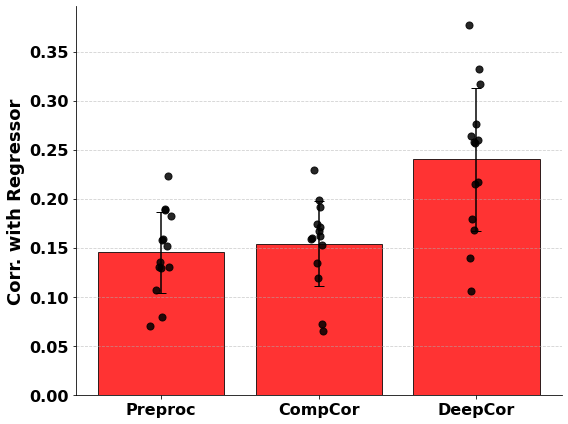

In [24]:
plt.figure(figsize=(8,6))
arrs = [face_preproc_vals,face_compcor_vals,face_signal_vals]
group_labels = ['Preproc','CompCor','DeepCor']
bar_color = 'red'
pretty_bar_plot(arrs,group_labels,bar_color)

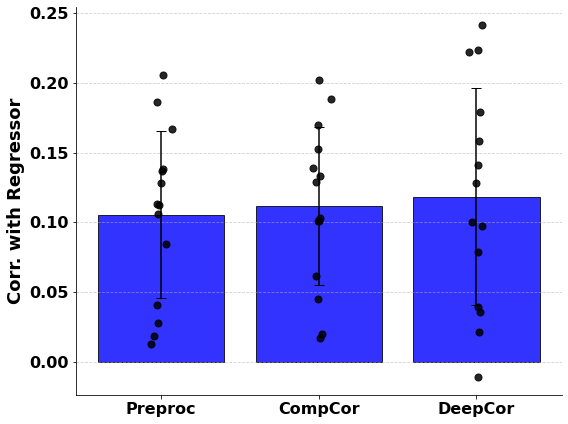

In [25]:
plt.figure(figsize=(8,6))
arrs = [place_preproc_vals,place_compcor_vals,place_signal_vals]
group_labels = ['Preproc','CompCor','DeepCor']
bar_color = 'blue'
pretty_bar_plot(arrs,group_labels,bar_color)

In [26]:
pretty_t_test_rel(place_compcor_vals,place_preproc_vals,'Place: CompCor > Preproc')
pretty_t_test_rel(place_signal_vals,place_compcor_vals,'Place: DeepCor > CompCor')
print('\n')
pretty_t_test_rel(face_compcor_vals,face_preproc_vals,'Face: CompCor > Preproc')
pretty_t_test_rel(face_signal_vals,face_compcor_vals,'Face: DeepCor > CompCor')

Place: CompCor > PreprocΔM=0.01,t(13) = 1.24, p = 0.236
Place: DeepCor > CompCorΔM=0.01,t(13) = 0.25, p = 0.810


Face: CompCor > PreprocΔM=0.01,t(13) = 1.94, p = 0.074
Face: DeepCor > CompCorΔM=0.09,t(13) = 3.42, p = 0.005
